### Imports

In [26]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/federica_lorenzini/ml-lab1/mlfs-book
HopsworksSettings initialized!


In [27]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [28]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 12, 56, 52, 903347)

### Connect to Hopsworks Feature Store

In [29]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_BERLIN_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']

2025-11-18 12:56:54,421 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 12:56:54,491 INFO: Initializing external client
2025-11-18 12:56:54,492 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-18 12:56:55,323 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-18 12:56:55,929 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279175


### Download the model from Model Registry

In [30]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_berlin",
    version=2,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 12:57:01,635 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/591676 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98153 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94714 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/97803 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98609 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94609 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94313 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94704 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94291 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/93378 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/98994 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27327 elapsed<00:00 remaining<?

In [31]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor(enable_categorical=True)

retrieved_xgboost_model.load_model(saved_model_dir + "/model_berlin.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.686384E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None,
             feature_types=['c', 'float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Get Weather Forecast Features with Feature View



In [32]:
weather_fg = fs.get_feature_group(
    name='weather_berlin',
    version=1,
)

# To avoid hourly discrepancies, we filter dates > than yesterday (rather than >= today)
batch_data = weather_fg.filter(weather_fg.date > today-datetime.timedelta(days=1)).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.63s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-18 00:00:00+00:00,5.35,0.0,19.645580,256.218384,Berlin
1,2025-11-19 00:00:00+00:00,4.45,0.0,13.698934,176.987274,Berlin
2,2025-11-20 00:00:00+00:00,3.75,0.0,15.986595,262.234924,Berlin
3,2025-11-22 00:00:00+00:00,2.70,0.0,6.792466,237.994659,Berlin
4,2025-11-21 00:00:00+00:00,2.55,0.0,5.001280,329.743652,Berlin
5,2025-11-23 00:00:00+00:00,2.15,0.0,2.880000,90.000000,Berlin
6,2025-11-24 00:00:00+00:00,1.05,0.0,8.350138,262.568695,Berlin


### Get today's PM25

In [33]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_berlin',
    version=1,
)

pm25_today = air_quality_fg.filter(air_quality_fg.date > (today-datetime.timedelta(days=1))).read()
pm25_today

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 


,date,pm25,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,country,city,street,url
0,2025-11-18 00:00:00+00:00,34.0,46.0,34.0,19.0,Germany,Berlin,karl-marx-strasse,https://api.waqi.info/feed/@13851
1,2025-11-18 00:00:00+00:00,21.0,25.0,13.0,16.0,Germany,Berlin,friedrichshagen,https://api.waqi.info/feed/@10034
2,2025-11-18 00:00:00+00:00,34.0,46.0,30.0,16.0,Germany,Berlin,neukolln-silbersteinstrasse,https://api.waqi.info/feed/@10036
3,2025-11-18 00:00:00+00:00,30.0,42.0,17.0,14.0,Germany,Berlin,neukolln-nansenstrasse,https://api.waqi.info/feed/@10032
4,2025-11-18 00:00:00+00:00,30.0,38.0,17.0,13.0,Germany,Berlin,wedding-amrumer-strasse,https://api.waqi.info/feed/@10030
5,2025-11-18 00:00:00+00:00,30.0,42.0,17.0,12.0,Germany,Berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039
6,2025-11-18 00:00:00+00:00,21.0,25.0,13.0,11.0,Germany,Berlin,buch,https://api.waqi.info/feed/@10033
7,2025-11-18 00:00:00+00:00,42.0,53.0,21.0,18.0,Germany,Berlin,mariendorf--mariendorfer-damm,https://api.waqi.info/feed/@10040
8,2025-11-18 00:00:00+00:00,30.0,42.0,17.0,15.0,Germany,Berlin,karl-liebknecht-strasse,https://api.waqi.info/feed/@6132
9,2025-11-18 00:00:00+00:00,34.0,46.0,17.0,17.0,Germany,Berlin,leipziger-strasse,https://api.waqi.info/feed/@13852


In [34]:
# Sort batch_data
batch_data = batch_data.sort_values(by=['date'], ignore_index=True)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-18 00:00:00+00:00,5.35,0.0,19.645580,256.218384,Berlin
1,2025-11-19 00:00:00+00:00,4.45,0.0,13.698934,176.987274,Berlin
2,2025-11-20 00:00:00+00:00,3.75,0.0,15.986595,262.234924,Berlin
3,2025-11-21 00:00:00+00:00,2.55,0.0,5.001280,329.743652,Berlin
4,2025-11-22 00:00:00+00:00,2.70,0.0,6.792466,237.994659,Berlin
5,2025-11-23 00:00:00+00:00,2.15,0.0,2.880000,90.000000,Berlin
6,2025-11-24 00:00:00+00:00,1.05,0.0,8.350138,262.568695,Berlin


### Making the predictions

In [35]:
# Just in case there are more rows retrieved
pm25_today = pm25_today.sort_values(by=['date'], ascending=False)

result_df = pd.DataFrame()
datapoint = pd.DataFrame()
datapoint = pm25_today[['pm25_lagged_1', 'pm25_lagged_2', 'pm25_lagged_3', 'street']].copy()
datapoint['street'] = datapoint['street'].astype("category")

# For each day in batch_data (7 days)
for i in range(batch_data.shape[0]):
    datapoint['temperature_2m_mean'] = batch_data.iloc[i]['temperature_2m_mean']
    datapoint['precipitation_sum'] = batch_data.iloc[i]['precipitation_sum']
    datapoint['wind_speed_10m_max'] = batch_data.iloc[i]['wind_speed_10m_max']
    datapoint['wind_direction_10m_dominant'] = batch_data.iloc[i]['wind_direction_10m_dominant']

    # Reorder columns (the model requires a certain order)
    datapoint = datapoint[['street', 'pm25_lagged_1', 'pm25_lagged_2', 'pm25_lagged_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
    pm25_predicted = retrieved_xgboost_model.predict(datapoint)

    datapoint['predicted_pm25'] = pd.DataFrame(pm25_predicted)
    datapoint['date'] = batch_data.iloc[i]['date']
    datapoint['days_before_forecast_day'] = i

    result_df = pd.concat([result_df, datapoint], ignore_index=True)

    datapoint['pm25_lagged_3'] = datapoint['pm25_lagged_2']
    datapoint['pm25_lagged_2'] = datapoint['pm25_lagged_1']
    datapoint['pm25_lagged_1'] = datapoint['predicted_pm25']

batch_data = result_df

batch_data

,street,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,date,days_before_forecast_day
0,karl-marx-strasse,46.000000,34.000000,19.000000,5.35,0.0,19.645580,256.218384,42.852455,2025-11-18 00:00:00+00:00,0
1,friedrichshagen,25.000000,13.000000,16.000000,5.35,0.0,19.645580,256.218384,39.911263,2025-11-18 00:00:00+00:00,0
2,neukolln-silbersteinstrasse,46.000000,30.000000,16.000000,5.35,0.0,19.645580,256.218384,53.625759,2025-11-18 00:00:00+00:00,0
3,neukolln-nansenstrasse,42.000000,17.000000,14.000000,5.35,0.0,19.645580,256.218384,46.225388,2025-11-18 00:00:00+00:00,0
4,wedding-amrumer-strasse,38.000000,17.000000,13.000000,5.35,0.0,19.645580,256.218384,39.725628,2025-11-18 00:00:00+00:00,0
...,...,...,...,...,...,...,...,...,...,...,...
65,mitte--bruckenstrasse,46.800140,47.640671,36.974358,1.05,0.0,8.350138,262.568695,49.319462,2025-11-24 00:00:00+00:00,6
66,buch,34.647930,41.403107,32.191628,1.05,0.0,8.350138,262.568695,44.145874,2025-11-24 00:00:00+00:00,6
67,mariendorf--mariendorfer-damm,57.321247,60.496906,47.114216,1.05,0.0,8.350138,262.568695,54.586914,2025-11-24 00:00:00+00:00,6
68,karl-liebknecht-strasse,59.591221,60.800266,47.897366,1.05,0.0,8.350138,262.568695,60.233444,2025-11-24 00:00:00+00:00,6


In [36]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   street                       70 non-null     category               
 1   pm25_lagged_1                70 non-null     float32                
 2   pm25_lagged_2                70 non-null     float32                
 3   pm25_lagged_3                70 non-null     float32                
 4   temperature_2m_mean          70 non-null     float32                
 5   precipitation_sum            70 non-null     float32                
 6   wind_speed_10m_max           70 non-null     float32                
 7   wind_direction_10m_dominant  70 non-null     float32                
 8   predicted_pm25               70 non-null     float32                
 9   date                         70 non-null     datetime64[us, Etc/UTC]
 10  days

### Saving the predictions (for monitoring) to a Feature Group

In [37]:
batch_data['city'] = city
batch_data['country'] = country

batch_data = batch_data.sort_values(by=['date'])
batch_data

,street,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,date,days_before_forecast_day,city,country
0,karl-marx-strasse,46.000000,34.000000,19.000000,5.35,0.0,19.645580,256.218384,42.852455,2025-11-18 00:00:00+00:00,0,Berlin,Germany
1,friedrichshagen,25.000000,13.000000,16.000000,5.35,0.0,19.645580,256.218384,39.911263,2025-11-18 00:00:00+00:00,0,Berlin,Germany
2,neukolln-silbersteinstrasse,46.000000,30.000000,16.000000,5.35,0.0,19.645580,256.218384,53.625759,2025-11-18 00:00:00+00:00,0,Berlin,Germany
3,neukolln-nansenstrasse,42.000000,17.000000,14.000000,5.35,0.0,19.645580,256.218384,46.225388,2025-11-18 00:00:00+00:00,0,Berlin,Germany
4,wedding-amrumer-strasse,38.000000,17.000000,13.000000,5.35,0.0,19.645580,256.218384,39.725628,2025-11-18 00:00:00+00:00,0,Berlin,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,wedding-amrumer-strasse,42.794071,40.508408,33.056732,1.05,0.0,8.350138,262.568695,45.870461,2025-11-24 00:00:00+00:00,6,Berlin,Germany
65,mitte--bruckenstrasse,46.800140,47.640671,36.974358,1.05,0.0,8.350138,262.568695,49.319462,2025-11-24 00:00:00+00:00,6,Berlin,Germany
66,buch,34.647930,41.403107,32.191628,1.05,0.0,8.350138,262.568695,44.145874,2025-11-24 00:00:00+00:00,6,Berlin,Germany
67,mariendorf--mariendorfer-damm,57.321247,60.496906,47.114216,1.05,0.0,8.350138,262.568695,54.586914,2025-11-24 00:00:00+00:00,6,Berlin,Germany


In [38]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 0 to 69
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   street                       70 non-null     category               
 1   pm25_lagged_1                70 non-null     float32                
 2   pm25_lagged_2                70 non-null     float32                
 3   pm25_lagged_3                70 non-null     float32                
 4   temperature_2m_mean          70 non-null     float32                
 5   precipitation_sum            70 non-null     float32                
 6   wind_speed_10m_max           70 non-null     float32                
 7   wind_direction_10m_dominant  70 non-null     float32                
 8   predicted_pm25               70 non-null     float32                
 9   date                         70 non-null     datetime64[us, Etc/UTC]
 10  days_befo

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo.
Show it on github pages

In [39]:
metadata = pd.DataFrame()
metadata['street'] = batch_data['street'].drop_duplicates()  
metadata

,street
0,karl-marx-strasse
1,friedrichshagen
2,neukolln-silbersteinstrasse
3,neukolln-nansenstrasse
4,wedding-amrumer-strasse
5,mitte--bruckenstrasse
6,buch
7,mariendorf--mariendorfer-damm
8,karl-liebknecht-strasse
9,leipziger-strasse


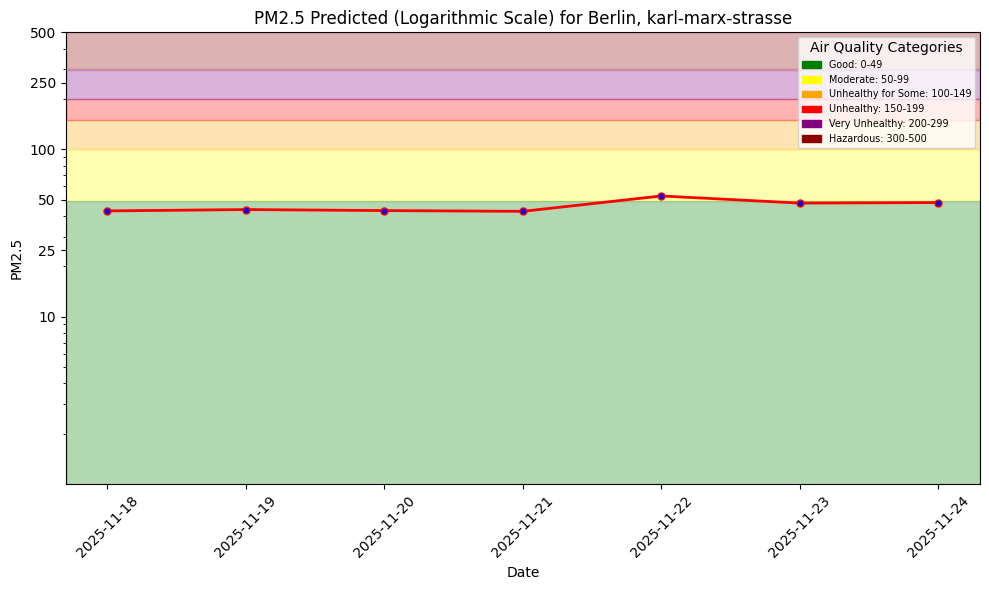

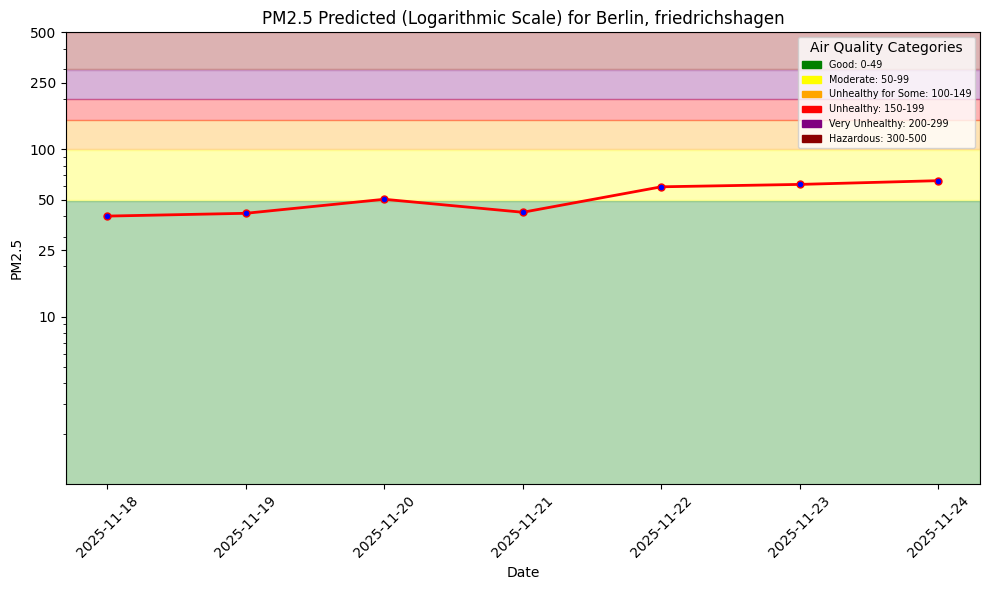

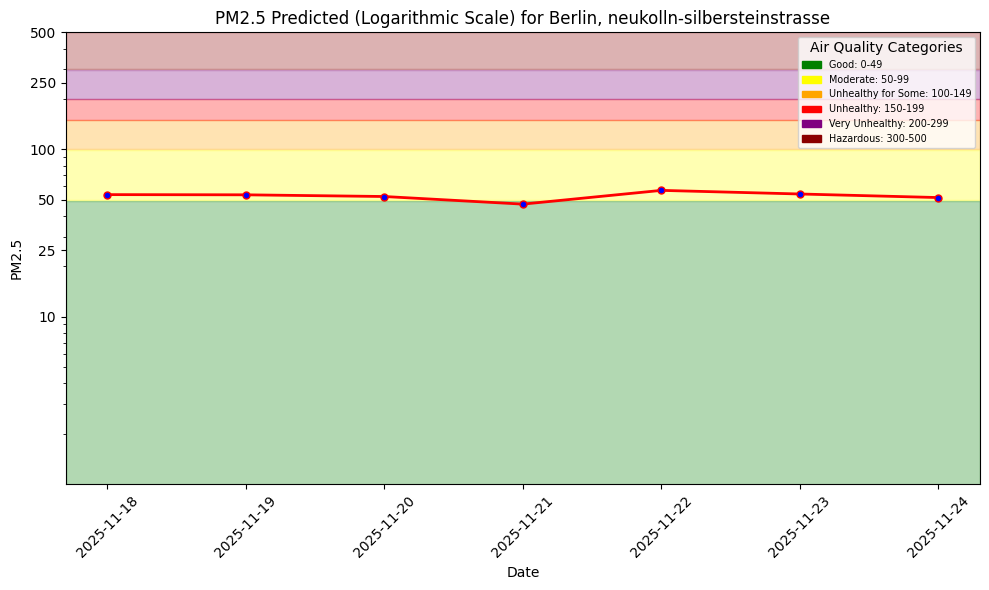

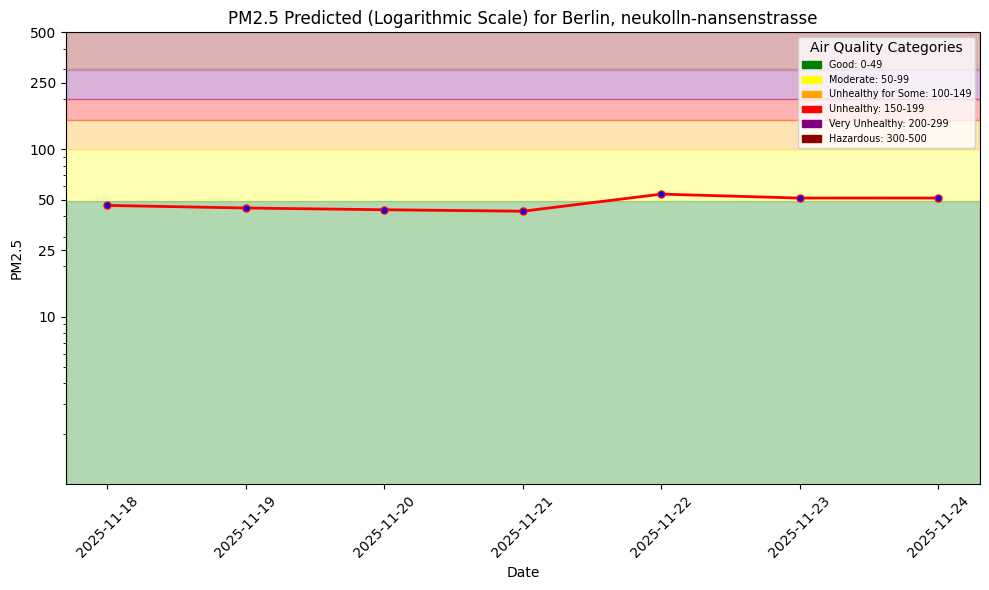

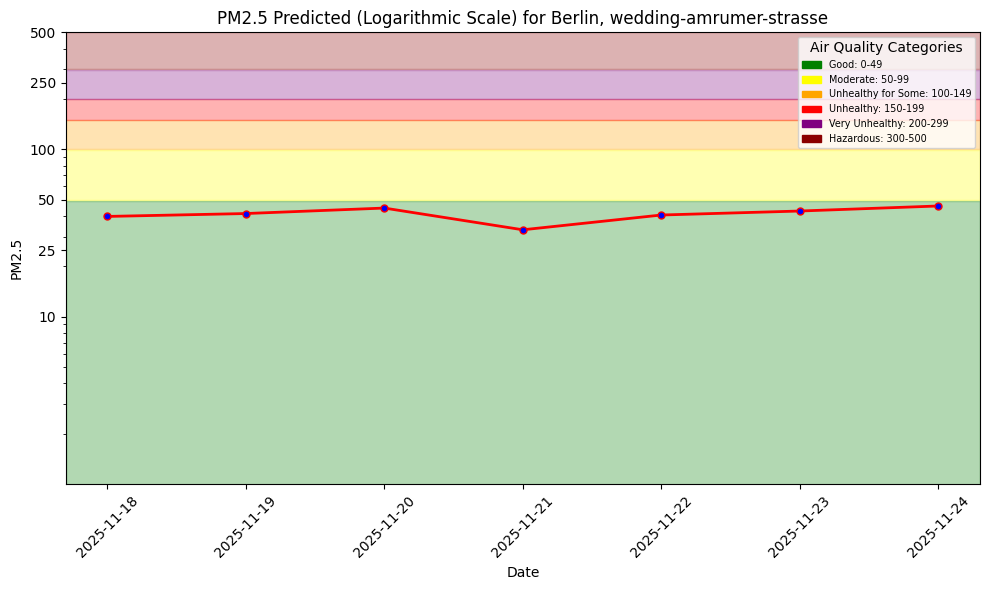

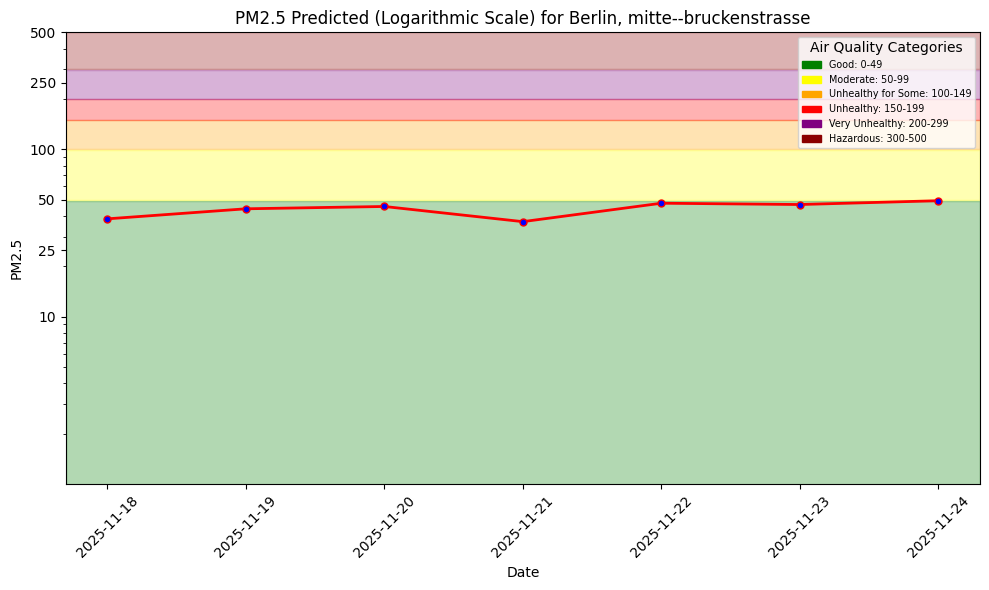

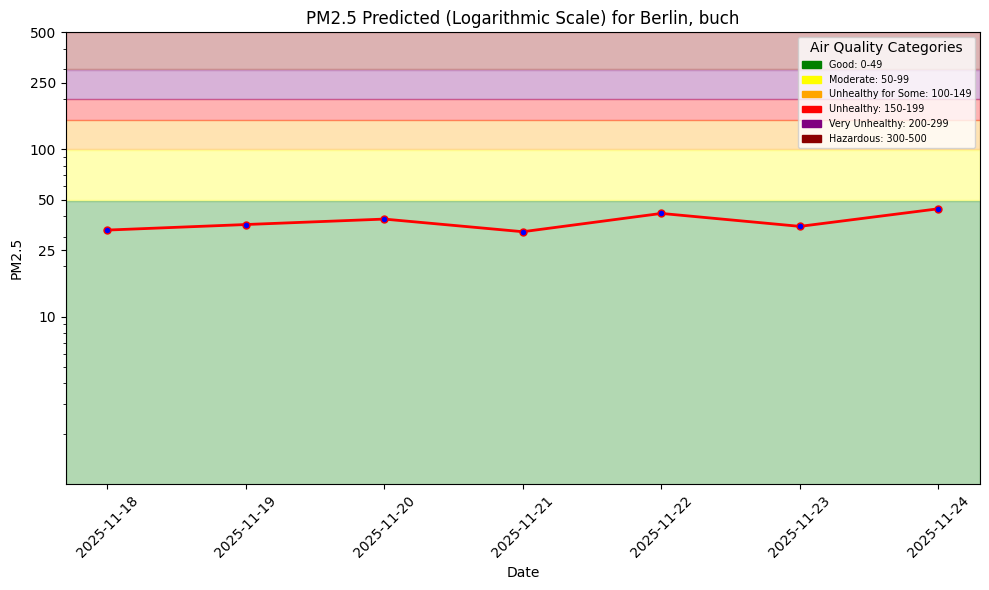

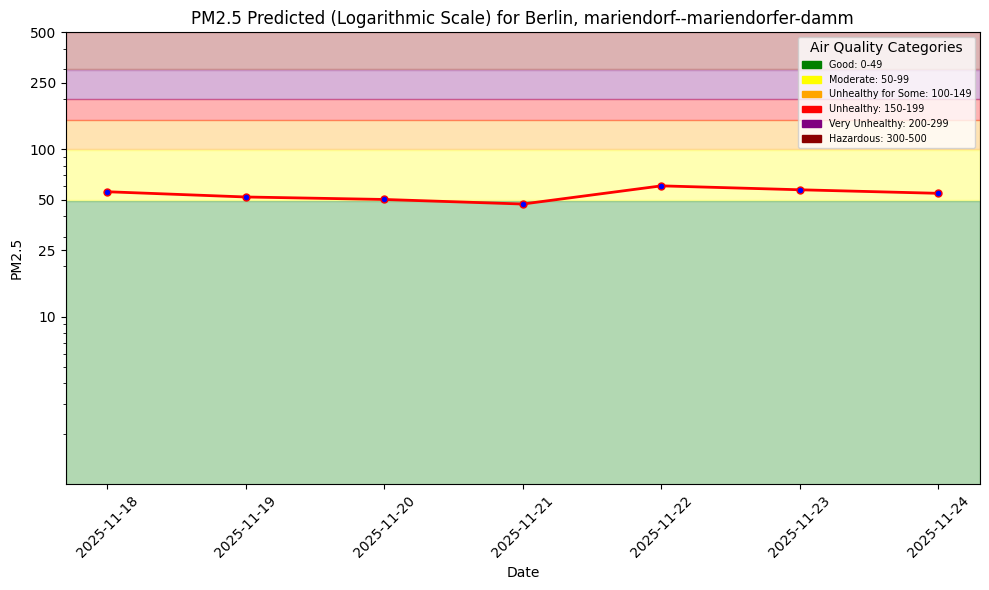

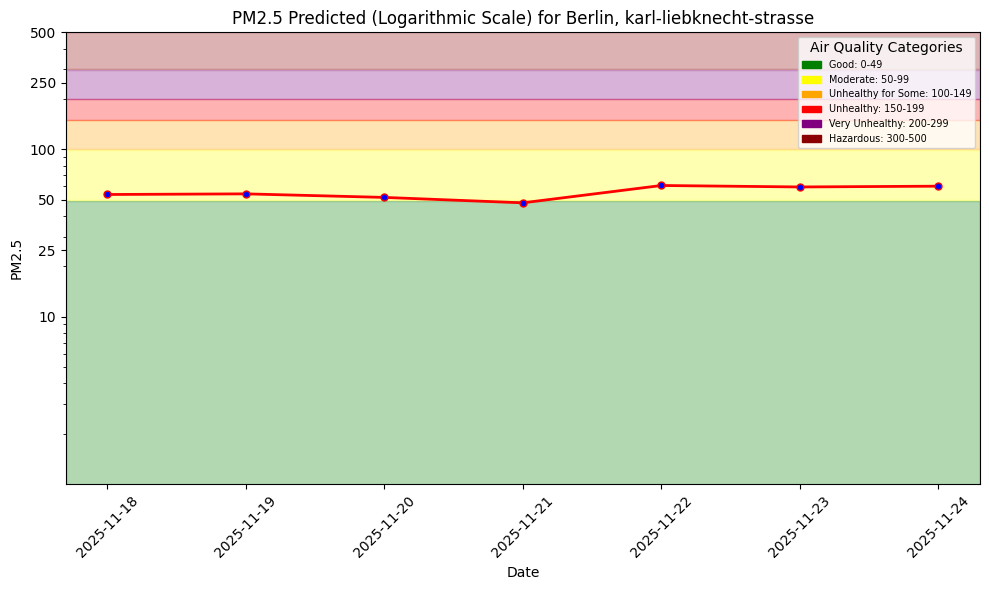

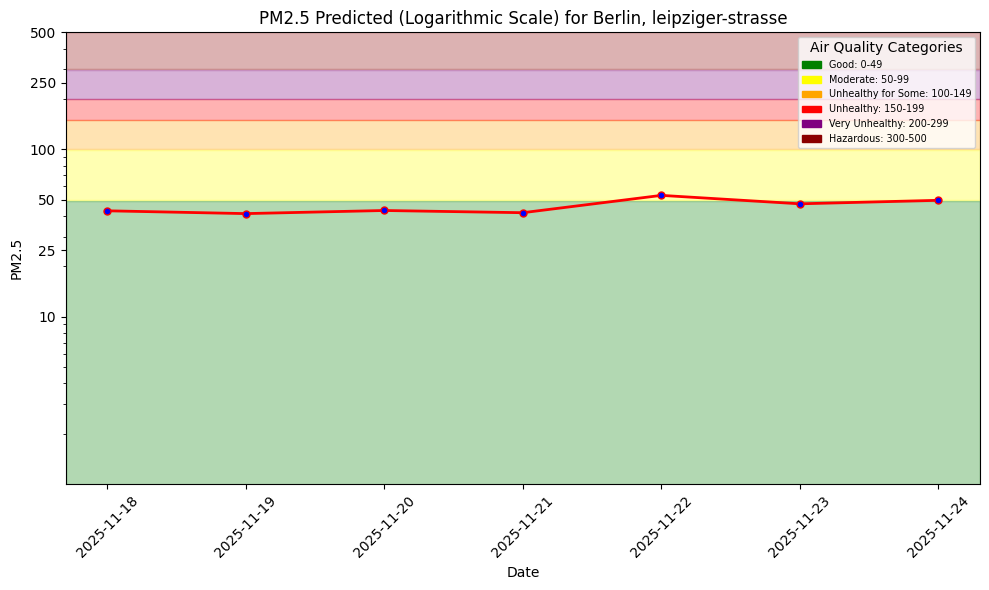

In [40]:
for i in range(metadata.shape[0]):
    street = metadata.iloc[i]['street']
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_"+street+".png"
    batch_data_i = batch_data[batch_data['street'] == street]
    plt = util.plot_air_quality_forecast(city, street, batch_data_i, pred_file_path)
plt.show()

In [41]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_berlin',
    description='Air Quality prediction monitoring for Berlin',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [42]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 70/70 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_berlin_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279175/jobs/named/aq_predictions_berlin_1_offline_fg_materialization/executions
2025-11-18 12:58:27,875 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 12:58:31,033 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 13:00:25,136 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 13:00:25,337 INFO: Waiting for log aggregation to finish.
2025-11-18 13:00:33,956 INFO: Execution finished successfully.


(Job('aq_predictions_berlin_1_offline_fg_materialization', 'SPARK'), None)

In [43]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 


,street,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,date,days_before_forecast_day,city,country
0,buch,13.000000,11.0,38.0,5.600000,0.0,11.709688,315.000092,21.201523,2025-11-17 00:00:00+00:00,1,Berlin,Germany
1,neukolln-nansenstrasse,17.000000,14.0,48.0,5.600000,0.0,11.709688,315.000092,28.308147,2025-11-17 00:00:00+00:00,1,Berlin,Germany
2,wedding-amrumer-strasse,17.000000,13.0,47.0,5.600000,0.0,11.709688,315.000092,27.300888,2025-11-17 00:00:00+00:00,1,Berlin,Germany
3,leipziger-strasse,17.000000,17.0,51.0,5.600000,0.0,11.709688,315.000092,30.609676,2025-11-17 00:00:00+00:00,1,Berlin,Germany
4,karl-marx-strasse,34.000000,19.0,52.0,5.600000,0.0,11.709688,315.000092,39.960510,2025-11-17 00:00:00+00:00,1,Berlin,Germany
5,friedrichshagen,13.000000,16.0,54.0,5.600000,0.0,11.709688,315.000092,30.318336,2025-11-17 00:00:00+00:00,1,Berlin,Germany
6,neukolln-silbersteinstrasse,30.000000,16.0,52.0,5.600000,0.0,11.709688,315.000092,38.974941,2025-11-17 00:00:00+00:00,1,Berlin,Germany
7,karl-liebknecht-strasse,17.000000,15.0,55.0,5.600000,0.0,11.709688,315.000092,30.606155,2025-11-17 00:00:00+00:00,1,Berlin,Germany
8,mitte--bruckenstrasse,17.000000,12.0,47.0,5.600000,0.0,11.709688,315.000092,30.325975,2025-11-17 00:00:00+00:00,1,Berlin,Germany
9,mariendorf--mariendorfer-damm,21.000000,18.0,53.0,5.600000,0.0,11.709688,315.000092,34.295467,2025-11-17 00:00:00+00:00,1,Berlin,Germany


In [44]:
air_quality_fg = fs.get_feature_group(name='air_quality_berlin', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.13s) 


,date,pm25,pm25_lagged_1,pm25_lagged_2,pm25_lagged_3,country,city,street,url
0,2025-03-12 00:00:00+00:00,84.0,133.0,133.0,122.0,Germany,Berlin,friedrichshagen,https://api.waqi.info/feed/@10034
1,2024-10-15 00:00:00+00:00,42.0,41.0,32.0,43.0,Germany,Berlin,neukolln-silbersteinstrasse,https://api.waqi.info/feed/@10036
2,2024-01-20 00:00:00+00:00,65.0,56.0,86.0,68.0,Germany,Berlin,karl-liebknecht-strasse,https://api.waqi.info/feed/@6132
3,2025-02-27 00:00:00+00:00,56.0,73.0,57.0,50.0,Germany,Berlin,wedding-amrumer-strasse,https://api.waqi.info/feed/@10030
4,2023-10-19 00:00:00+00:00,73.0,57.0,48.0,29.0,Germany,Berlin,mariendorf--mariendorfer-damm,https://api.waqi.info/feed/@10040
...,...,...,...,...,...,...,...,...,...
12939,2025-11-18 00:00:00+00:00,30.0,42.0,17.0,12.0,Germany,Berlin,mitte--bruckenstrasse,https://api.waqi.info/feed/@10039
12940,2025-11-18 00:00:00+00:00,21.0,25.0,13.0,11.0,Germany,Berlin,buch,https://api.waqi.info/feed/@10033
12941,2025-11-18 00:00:00+00:00,42.0,53.0,21.0,18.0,Germany,Berlin,mariendorf--mariendorfer-damm,https://api.waqi.info/feed/@10040
12942,2025-11-18 00:00:00+00:00,30.0,42.0,17.0,15.0,Germany,Berlin,karl-liebknecht-strasse,https://api.waqi.info/feed/@6132


In [45]:
outcome_df = air_quality_df[['date', 'pm25', 'street']]
preds_df =  monitoring_df[['date', 'predicted_pm25', 'street']]

hindcast_df = pd.merge(preds_df, outcome_df, on=["date","street"])
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring_berlin(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,street,pm25
19,2025-11-14 00:00:00+00:00,45.843227,buch,38.0
31,2025-11-14 00:00:00+00:00,53.032291,leipziger-strasse,51.0
28,2025-11-14 00:00:00+00:00,49.442245,mitte--bruckenstrasse,47.0
27,2025-11-14 00:00:00+00:00,51.486713,neukolln-nansenstrasse,48.0
24,2025-11-14 00:00:00+00:00,54.156738,karl-marx-strasse,52.0
11,2025-11-14 00:00:00+00:00,55.514351,mariendorf--mariendorfer-damm,53.0
12,2025-11-14 00:00:00+00:00,54.931736,friedrichshagen,54.0
23,2025-11-14 00:00:00+00:00,54.661007,karl-liebknecht-strasse,55.0
20,2025-11-14 00:00:00+00:00,46.301300,wedding-amrumer-strasse,47.0
38,2025-11-14 00:00:00+00:00,56.138851,neukolln-silbersteinstrasse,52.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

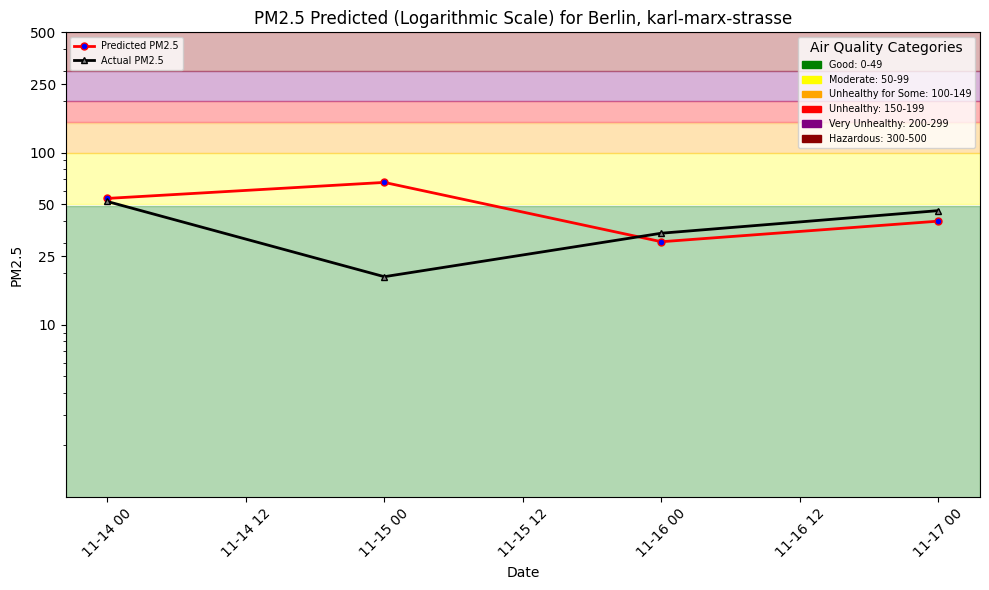

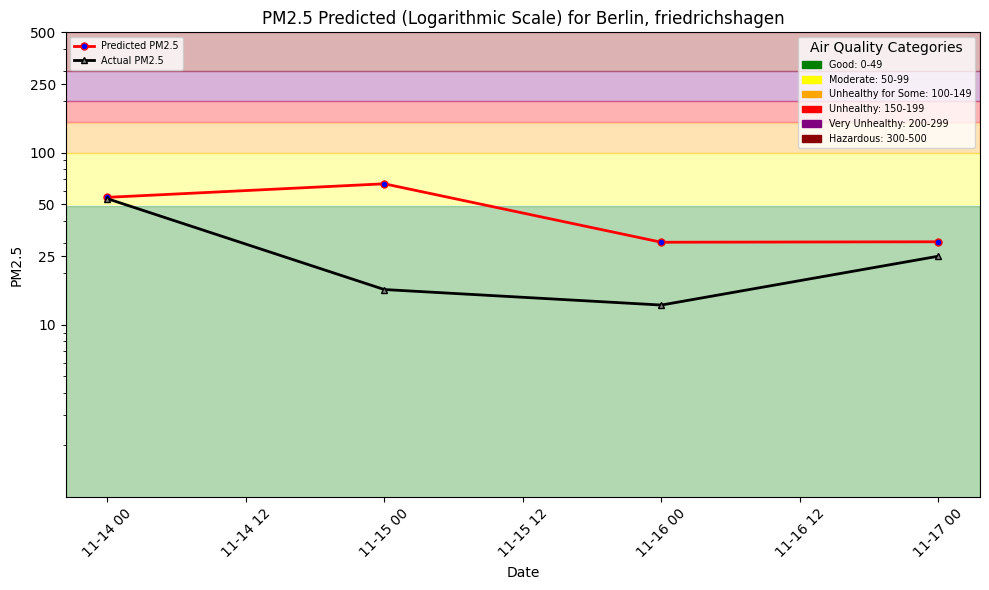

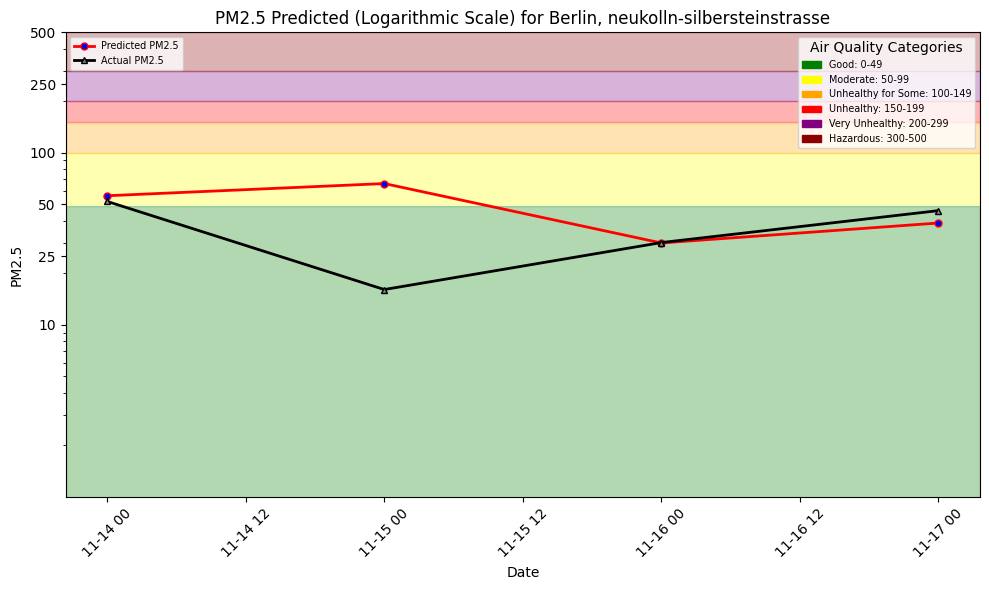

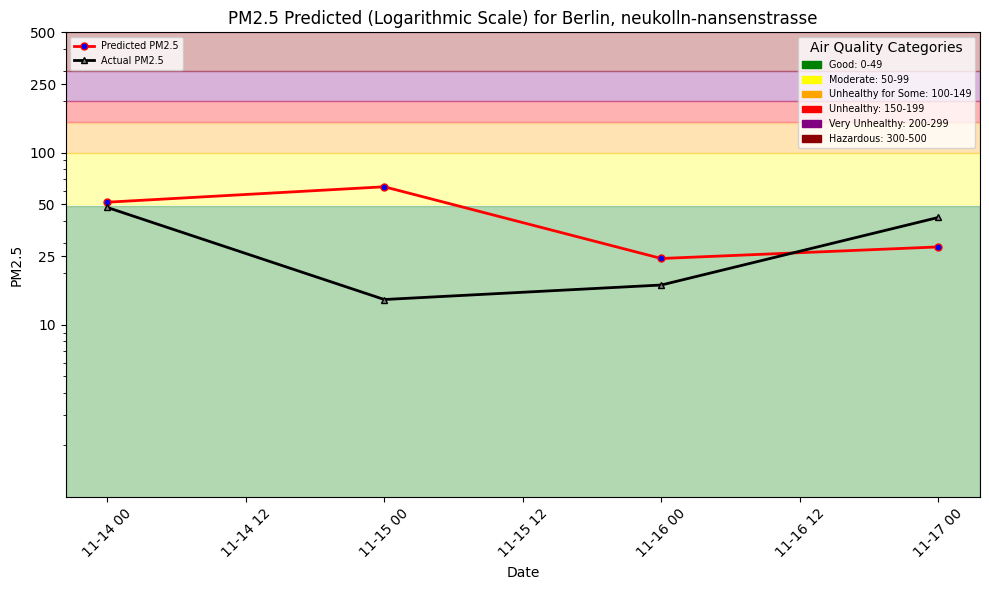

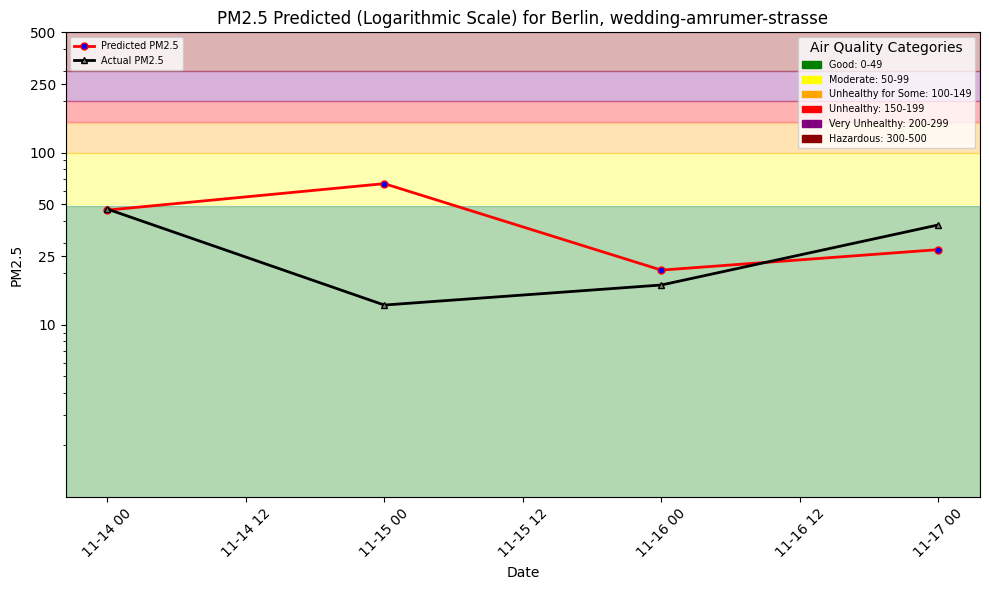

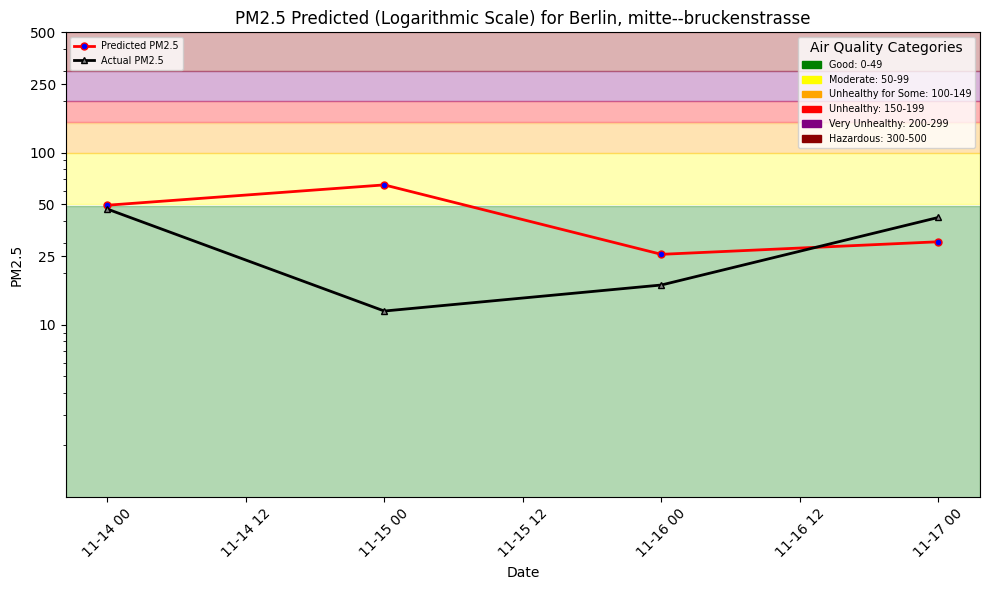

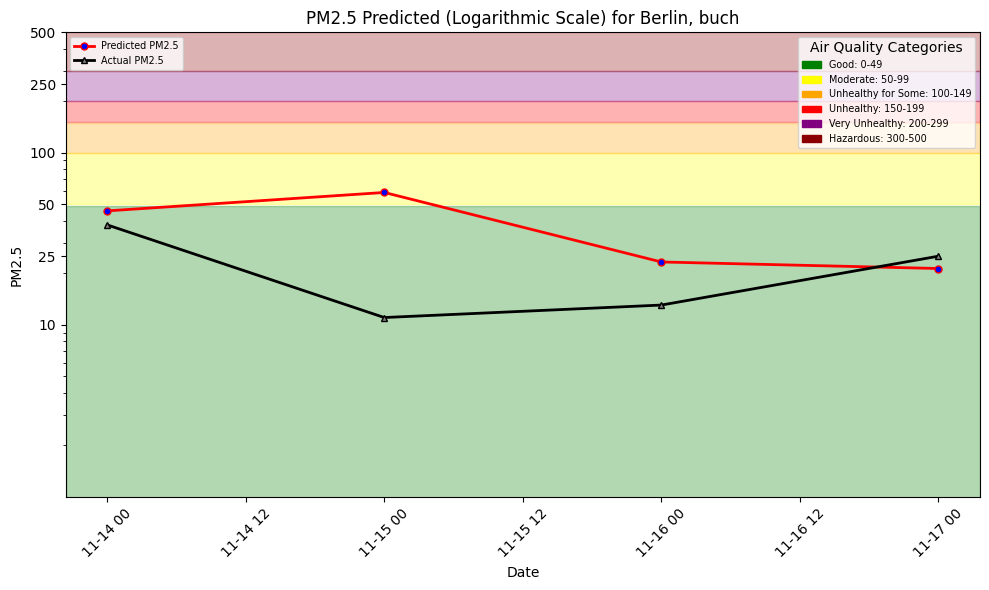

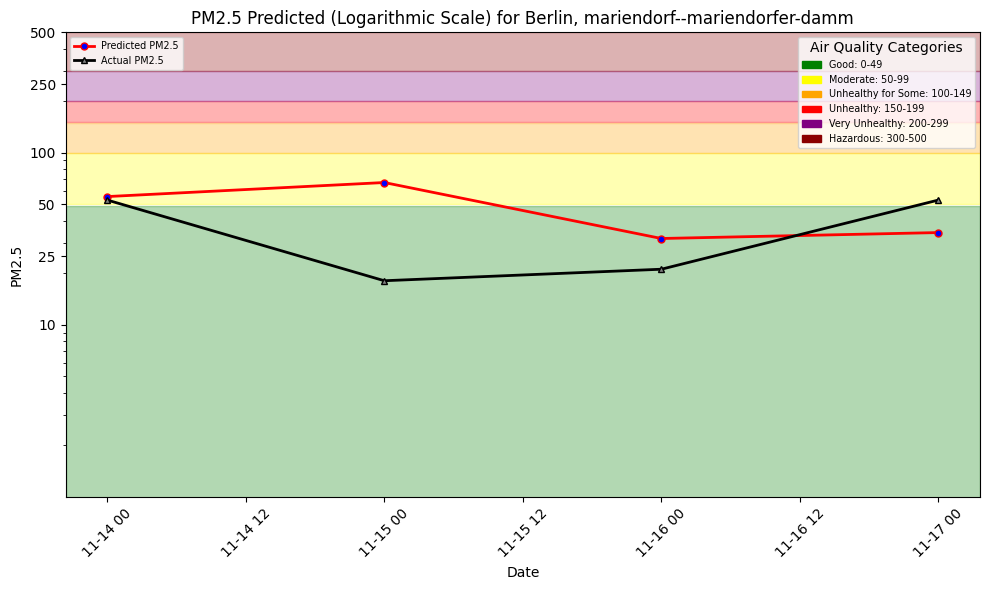

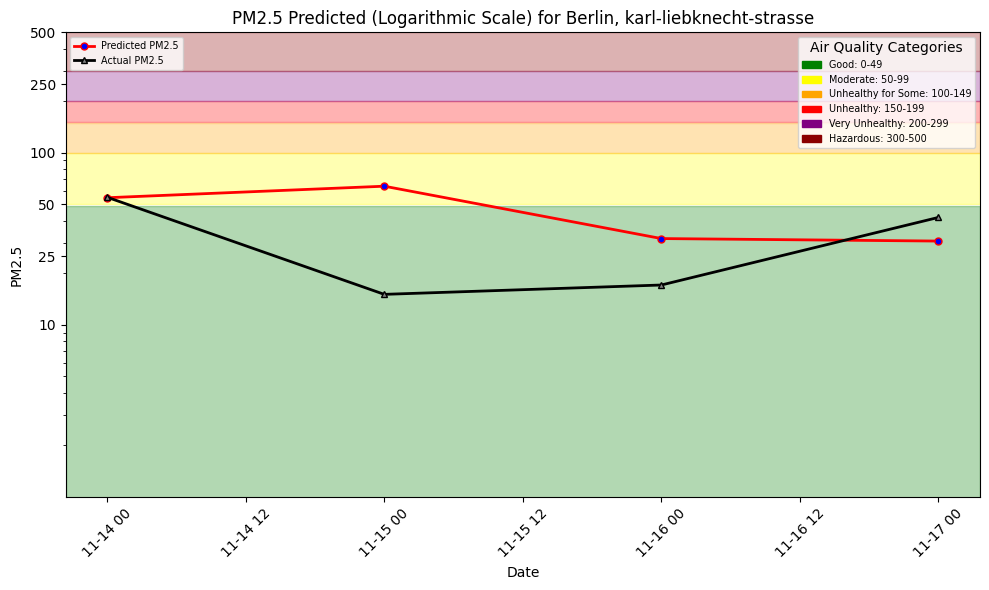

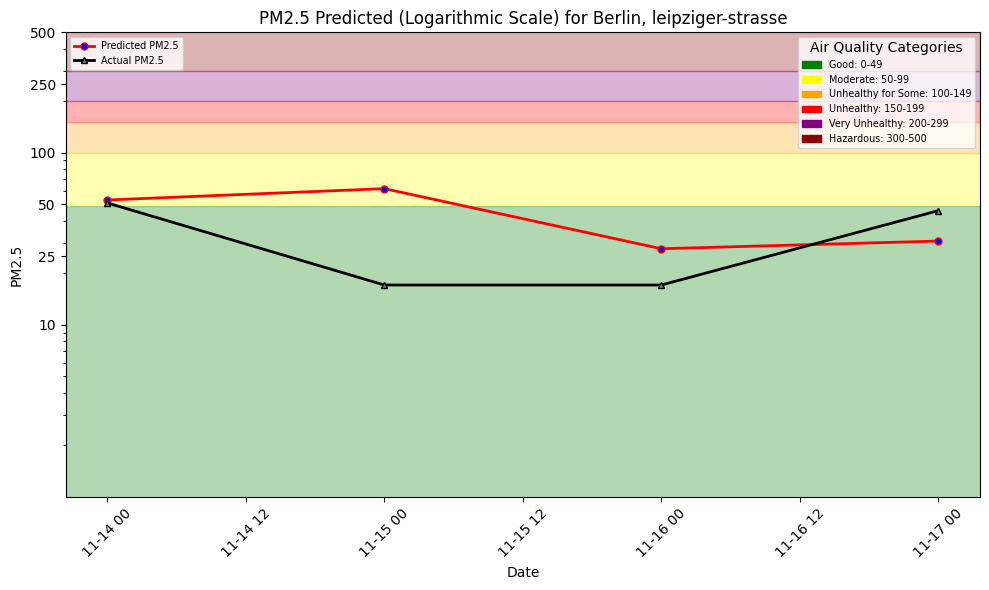

In [46]:
for i in range(metadata.shape[0]):
    street = metadata.iloc[i]['street']

    hindcast_df_i = hindcast_df[hindcast_df['street'] == street]
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_"+street+".png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df_i, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [48]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

for i in range(metadata.shape[0]):
    street = metadata.iloc[i]['street']

    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_"+street+".png"
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_"+street+".png"

    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_forecast_karl-marx-stras…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_karl-marx-…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_forecast_friedrichshagen…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_friedrichs…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_forecast_neukolln-silber…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_neukolln-s…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_forecast_neukolln-nansen…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_neukolln-n…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_forecast_wedding-amrumer…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_wedding-am…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_forecast_mitte--bruckens…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_mitte--bru…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_forecast_buch.png: 0.000…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_buch.png: …

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_forecast_mariendorf--mar…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_mariendorf…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_forecast_karl-liebknecht…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_karl-liebk…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_forecast_leipziger-stras…

Uploading /home/federica_lorenzini/ml-lab1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_leipziger-…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279175/settings/fb/path/Resources/airquality
